# Sentiment Analysis

The Sentiment analysis (also known as opinion mining or emotion AI) is the use of natural language processing, text analysis, computational linguistics, and biometrics to systematically identify, extract, quantify, and study affective states and subjective information (from Wikipedia).

In this example, we have to predict the number of positive and negative reviews based on sentiments. For sake of semplicity we'll use just one model based on the Naive Bayes approach. This to text classification is a good choice when the amount of training data is limited.

### Import data set

In [1]:
import pandas as pd

# from: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?select=IMDB+Dataset.csv
dfMovies = pd.read_csv(r'./data/IMDB Dataset.csv', engine="c", encoding='utf-8')

### Basic EDA and cleaning data

In [2]:
dfMovies.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


We note that some review beed to be cleaned (for example see the second review).

In [3]:
# Just use python variable replacement syntax to make the text dynamic.
from IPython.display import Markdown as md

md(f"The IMDb data set consists of {dfMovies.shape[1]} different parameters of wine which was measured for {dfMovies.shape[0]} review samples.")

The IMDb data set consists of 2 different parameters of wine which was measured for 50000 review samples.

Type data and memory usage

In [4]:
dfMovies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
print (dfMovies.applymap(type))

              review      sentiment
0      <class 'str'>  <class 'str'>
1      <class 'str'>  <class 'str'>
2      <class 'str'>  <class 'str'>
3      <class 'str'>  <class 'str'>
4      <class 'str'>  <class 'str'>
...              ...            ...
49995  <class 'str'>  <class 'str'>
49996  <class 'str'>  <class 'str'>
49997  <class 'str'>  <class 'str'>
49998  <class 'str'>  <class 'str'>
49999  <class 'str'>  <class 'str'>

[50000 rows x 2 columns]


All data are string even if in memory the are considered to be object data.
The next step is searching for missing, NA and null values. First of all verify is there are null or empty values.

In [6]:
(dfMovies.isnull() | dfMovies.empty).sum()

review       0
sentiment    0
dtype: int64

Second we can remove potential unwanted characters like HTML tags and special characters

In [7]:
import regex

def cleanText(text):
    # HTML tags
    text = regex.sub(r"<[^<]+?>","",text)
    # Special chars
    text = regex.sub(r"[^a-zA-Z0-9 ]","",text)
    text = text.lower()
    return text

In [8]:
dfMovies["review"] = dfMovies["review"].apply(cleanText)

As we can see, (for example) the second revies are cleaned now.

In [9]:
dfMovies.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


Let's show the summary statistics.

<AxesSubplot:xlabel='sentiment', ylabel='count'>

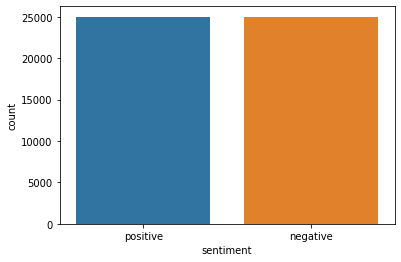

In [10]:
import seaborn as sns

sns.countplot(x=dfMovies['sentiment'])

It seems to be an ex-equo in both target values: the dataset is balanced.
Now we try make a visual representation of text data in order to show the importance of each word by font size or color.

In [11]:
from wordcloud import WordCloud
def makeWordCloud(bkColor, w, h, series, title, ax):
    wcl = WordCloud(background_color=bkColor,
                    width=w,
                    height=h).generate(" ".join(series))
    ax.imshow(wcl)
    ax.axis('off')
    ax.set_title(title, fontsize=40)

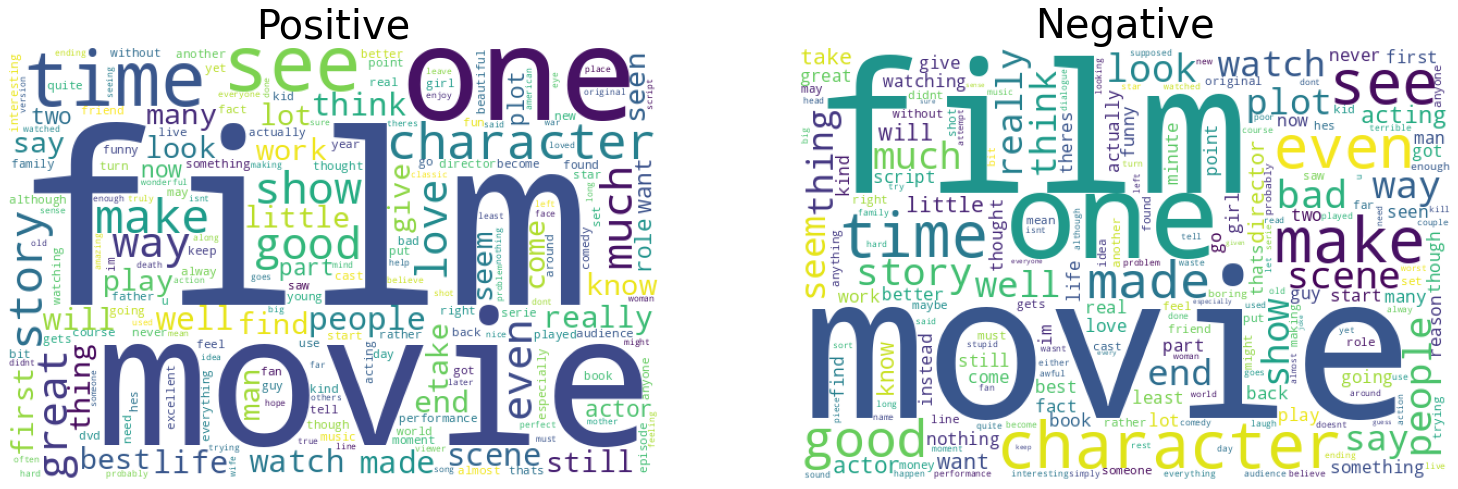

In [12]:
import matplotlib.pyplot as plt

positive = dfMovies[dfMovies['sentiment']=="positive"]['review']
negative = dfMovies[dfMovies['sentiment']=="negative"]['review']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
makeWordCloud("white", 600, 400, positive, "Positive", ax1)
makeWordCloud("white", 600, 400, negative, "Negative", ax2)
plt.show()

We note the most used words are "movie" and "film"; maybe can get rid off of these words without any consequences.

In [13]:
dfMovies["review"] = dfMovies["review"].str.replace("movie", "")
dfMovies["review"] = dfMovies["review"].str.replace("film", "")

A quick check:

In [14]:
dfMovies['review'].str.contains('movie').eq(True).all()

False

In [15]:
dfMovies['review'].str.contains('film').eq(True).all()

False

### Train and test the model

Computers cannot understand words, they can only understand numbers. For this purpose, <b>Countvectorizer</b> converts text to numerical data (more specifically, the text is transformed to a sparse matrix) by replacing all-knowing words with the number of times they appear. In a nutshell, the model will count how many times the word 'good' appears in a positive sentence, and then divide this number by how many times this word appears at all. For the negative score, "1 - Positive Score". This process is called vectorization.
Let's start with split review from sentiment.

In [16]:
X = dfMovies['review']
y = dfMovies['sentiment']

In the following code, you can see: <b>CountVectorizer(ngram_range=(1,2))</b>
This statement converts the text to lowercase (by default). About the ngram_range parameter, it lets you decide the sequence length of consecutive words in the given text. In the example, it will pick the unigram (that is only a single word) and bigram (group of two consecutive words).

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(ngram_range=(1,2))

For the sake of clarity, fit and transform statements are keep separated.
In the following line we show the mapping of terms.

In [18]:
vect.fit(X).vocabulary_

{'one': 1734328,
 'of': 1683535,
 'the': 2381259,
 'other': 1765922,
 'reviewers': 2012610,
 'has': 1068945,
 'mentioned': 1527800,
 'that': 2367502,
 'after': 71391,
 'watching': 2670669,
 'just': 1328151,
 'oz': 1791785,
 'episode': 786389,
 'youll': 2798030,
 'be': 274166,
 'hooked': 1151869,
 'they': 2446303,
 'are': 189381,
 'right': 2020486,
 'as': 207474,
 'this': 2456960,
 'is': 1263189,
 'exactly': 813914,
 'what': 2697627,
 'happened': 1061251,
 'with': 2739942,
 'methe': 1533210,
 'first': 889500,
 'thing': 2451188,
 'struck': 2287835,
 'me': 1512146,
 'about': 31528,
 'was': 2655872,
 'its': 1292308,
 'brutality': 384934,
 'and': 126652,
 'unflinching': 2582098,
 'scenes': 2076091,
 'violence': 2635761,
 'which': 2709160,
 'set': 2123626,
 'in': 1202074,
 'from': 944023,
 'word': 2764654,
 'go': 1001363,
 'trust': 2551966,
 'not': 1657480,
 'show': 2152248,
 'for': 909902,
 'faint': 842876,
 'hearted': 1091320,
 'or': 1750884,
 'timid': 2491723,
 'pulls': 1928654,
 'no': 16

and then, it will transform the input data.

In [19]:
X = vect.transform(X)
#print(X)

Now we can split in train and test datasets, in order to use validation data over test data.

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

We'll use the <b>BernoulliNB</b> (NB stands for Naive Bayes) will generate our classification model. 

<hr>
The Naive Bayes classifier uses the Bayes Theorem that represents the probability of an event based on the prior knowledge of the conditions that might be related to that event:

$P(\textrm{model} \mid \textrm{data}) = \frac{P(\textrm{data} \mid \textrm{model}) \, P(\textrm{model})}{P(\textrm{data})}$

In Bayes' equation, $P(\textrm{model})$ reflects our prior knowledge about the model. Also, $P(\textrm{data})$ is the distribution of the data. So we can rewrite as:

$P(\textrm{label} \mid \textrm{text}) = \frac{P(\textrm{label} \mid \textrm{text}) \, P(\textrm{label})}{P(\textrm{text})}$

where text --> word_1, word_2 and so on.

<b>BernoulliNB</b> is suitable for discrete data (binary/boolean features) that is what we got previously.

In [21]:
from sklearn.naive_bayes import BernoulliNB

model = BernoulliNB()

model.fit(X_train, y_train)

p_train = model.predict(X_train)
p_test = model.predict(X_test)

After these two scores are calculated we can compare each other, to check the performance of the classifier.

In [22]:
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_train, p_train)
acc_test = accuracy_score(y_test, p_test)

print(f'Train {acc_train}, Test {acc_test}')

Train 0.9918666666666667, Test 0.87648


### Model Performance Analysis

We'll use two measures:
1. Confusion matrix
2. Classification Report with Precision, Recall and F1-Score.

The confusion matrix is a table that is used to show the number of correct and incorrect predictions on a classification problem when the real values of the Test Set are known. It is of the format

|    |    |
|----|----|
| TP | FP |
| FN | TN |

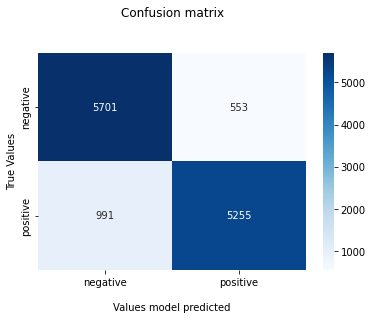

In [23]:
confusionMatrix = pd.crosstab(y_test, p_test)
fx = sns.heatmap(confusionMatrix, annot=True, cmap='Blues', fmt='d')
fx.set_title('Confusion matrix\n\n');
fx.set_xlabel('\nValues model predicted')
fx.set_ylabel('True Values')
plt.show()

In [24]:
from sklearn.metrics import classification_report

classificationReportNotScaled = classification_report(y_test, p_test)
print(f"Classification Report\n{classificationReportNotScaled}")

Classification Report
              precision    recall  f1-score   support

    negative       0.85      0.91      0.88      6254
    positive       0.90      0.84      0.87      6246

    accuracy                           0.88     12500
   macro avg       0.88      0.88      0.88     12500
weighted avg       0.88      0.88      0.88     12500

